In [1]:
import os
import pickle
import glob
import skimage
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import csv

import sys

sys.path.append('../functions')

import chirp_functions as proc
%matplotlib inline

In [2]:
### COMSOL data preprocessing code


header = []

freqs = np.linspace(2.0, 17.0, 650) # need to change this to match the frequencies in your COMSOL simulation
print(freqs)

setno = 0
targetfile = '../../data/kagome-0304-realspace/preprocessed/' # need to change this to match the destination



with open('../../data/kagome-0304-realspace/real_space_triangle.csv', newline='') as csvfile: # need to match the filepath of the COMSOL data
    reader = csv.reader(csvfile, delimiter=',')

    headerNum = 4
    for i in range(headerNum):
        next(reader)
        
    header = next(reader)
    dataPointNum = int((len(header)-1)/4)
    
    j=0
    for row in reader:
        real_data = []
        freq = freqs[j]
        
        for i in range(1, dataPointNum+1, 1):
            currentData = [float(row[i+dataPointNum*2]), float(row[i+dataPointNum*3]), float(row[i]), float(row[i+dataPointNum])/2/np.pi*360]
            real_data.append(currentData)
            
        np.array(real_data).dump(targetfile + '_' + str(freq) + '_' + str(setno) + '.pkl')
        
        j+=1

[ 2.          2.02311248  2.04622496  2.06933744  2.09244992  2.1155624
  2.13867488  2.16178737  2.18489985  2.20801233  2.23112481  2.25423729
  2.27734977  2.30046225  2.32357473  2.34668721  2.36979969  2.39291217
  2.41602465  2.43913713  2.46224961  2.4853621   2.50847458  2.53158706
  2.55469954  2.57781202  2.6009245   2.62403698  2.64714946  2.67026194
  2.69337442  2.7164869   2.73959938  2.76271186  2.78582435  2.80893683
  2.83204931  2.85516179  2.87827427  2.90138675  2.92449923  2.94761171
  2.97072419  2.99383667  3.01694915  3.04006163  3.06317411  3.08628659
  3.10939908  3.13251156  3.15562404  3.17873652  3.201849    3.22496148
  3.24807396  3.27118644  3.29429892  3.3174114   3.34052388  3.36363636
  3.38674884  3.40986133  3.43297381  3.45608629  3.47919877  3.50231125
  3.52542373  3.54853621  3.57164869  3.59476117  3.61787365  3.64098613
  3.66409861  3.68721109  3.71032357  3.73343606  3.75654854  3.77966102
  3.8027735   3.82588598  3.84899846  3.87211094  3.

In [3]:
## STEP 1: PREPROCESS EXPERIMENTAL DATA
proc.preprocess_chirp(data_dir = '../../data/kagome-02.26.2022-center/raw/real_space/', 
                       frequencies = np.linspace(1000.0, 18000.0, 426), 
                       targetfile = '../../data/kagome-02.26.2022-center/preprocessed_real/', 
                       title = 'scppos_', setno = 0)

Found 164 records
Preprocessing complete!


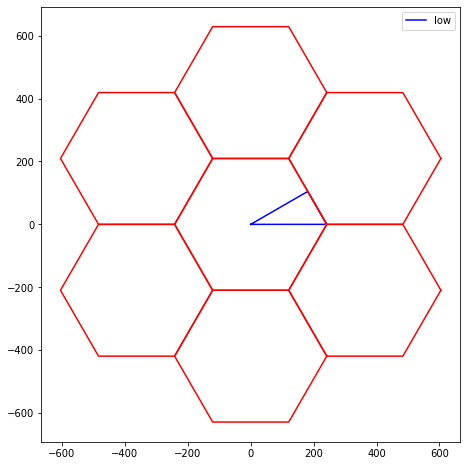

In [4]:
### STEP 2: Initializing the GKMG sweep


# need to change the min, max and number of frequencies. Also make sure that the units are in kHz!
freq_num = 426
freq_min = 1000.0
freq_max = 18000.0
freqs = np.array([(0, np.linspace(freq_min, freq_max, freq_num))], dtype=object)

freq_div = 9000.0 # Dirac frequency: frequency at which you switch to a different sweep


L = 0.01 # need to change this to match the scale factor in COMSOL (unit: m)
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)

b_res = 50 # number of b. You can make b larger to get higher k resolution
b = np.linspace(0, 1.5+np.sqrt(3)/2, b_res) #GKMG sweep parameter as in COMSOL

kxb_low = np.zeros(len(b))
kyb_low = np.zeros(len(b))
kxb_high = np.zeros(len(b))
kyb_high = np.zeros(len(b))


for i in range(len(b)):
    if b[i] < 1:        
        kxb_low[i] = 4 * np.pi / (3 * np.sqrt(3) * L) * b[i]
        kxb_low[i] = 4 * np.pi / (3 * L)  - 2*kymax

        kxb_high[i] = 
        
    elif b[i] < 1.5:         
        kxb_low[i] = 4 * np.pi / (3 * np.sqrt(3) * L) - 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kxb_low[i] = 4 * np.pi / (3*L) + 2 * np.pi / (3 * L) * (b[i]-1) - 2*kymax
        
    else:       
        kxb_low[i] = (1- (b[i] - 1.5) * 2 / np.sqrt(3)) * np.pi / (np.sqrt(3) * L)
        kxb_low[i] = 4 * np.pi / (3*L) + (1- 2 / (np.sqrt(3)) * (b[i]-1.5)) * np.pi / (3 * L) - 2*kymax




plt.figure(figsize=(8,8))
plt.plot(kxb, kyb, 'b-',label='low')
plt.legend()
ax = plt.gca()
ax.set_aspect('equal')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]


for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


In [5]:
### The actual Fourier Transform

filename = '../../data/kagome-02.26.2022-center/preprocessed_band/' # change this to match the preprocessed folder

reciprocal_data = np.zeros((freq_num, b_res))
#x_unit = 1e-3 # make sure you export the coordinates from COMSOL in meters
#y_unit = 1e-3

x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000

#G = [[0.0, 0.0], [6*np.pi/(3*np.sqrt(3) * L), 2*np.pi/(3*L)], [6*np.pi/(3*np.sqrt(3) * L), -2*np.pi/(3*L)], [0, 4*np.pi/(3*L)]]
    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f) 

 
            for i in range(b_res):
                #for k_no in range(4):
                k_current = [kxb[i], kyb[i]]
                amplitude = np.abs(np.array(
                        [point[2] * np.exp(1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                            for point in real_data]).sum())
                reciprocal_data[j][i] += amplitude


 

            

reciprocal_data_plot = np.zeros((freq_num, b_res))


for i in range(len(reciprocal_data)):
    reciprocal_data_plot[i] = reciprocal_data[i]

reciprocal_data_plot = reciprocal_data/np.max(reciprocal_data) # normalize data

100%|██████████| 426/426 [00:08<00:00, 48.49it/s]


/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later


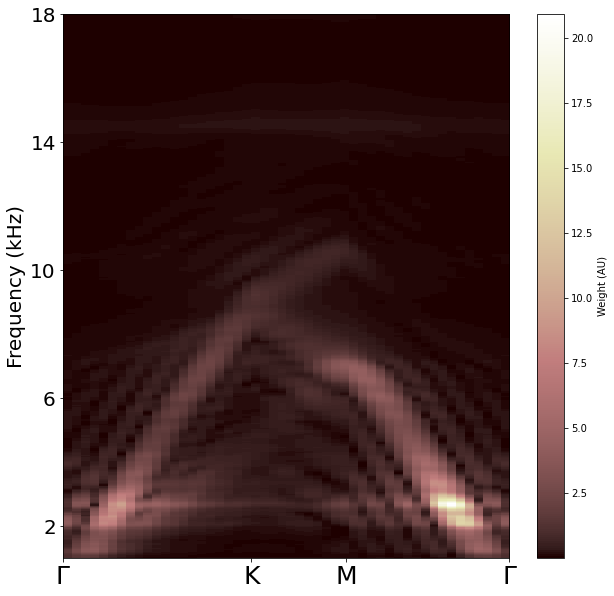

In [19]:
### Plot and save the band structure

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import matplotlib.cm as cm


folder = '../../data/kagome-02.26.2022-center/'

reciprocal_data_plot = reciprocal_data # normalize data

# Feel free to change the color map! Currently I'm using the one called "binary"


plt.figure(figsize = (10, 10))
plt.imshow(reciprocal_data_plot, cmap = 'pink', extent = [b[0], b[-1], freq_min/1e3, freq_max/1e3], aspect = 'auto', origin = 'lower', interpolation='none')
plt.axis([b[0], b[-1], 1, 18])
plt.colorbar(label = 'Weight (AU)')
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.yticks(np.linspace(2, 18, 5), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.savefig(folder + "fourier/figures/band_structure.png", interpolation='none')